<a href="https://colab.research.google.com/github/wint3rx3/flowers_classification/blob/main/VGG16.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

1. 필요한 라이브러리 설치

In [ ]:
import os
import glob
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.applications import VGG16
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Flatten, Dense
from tensorflow.keras.optimizers import Adam

2. 데이터셋 다운로드 준비

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

!kaggle datasets download -d imsparsh/flowers-dataset

import zipfile

zip_path = "flowers-dataset.zip"
extract_path = "./flowers-dataset"

with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)

TRAIN_DIR = '/content/flowers-dataset/train'
TEST_DIR  = '/content/flowers-dataset/test'

classes = sorted(os.listdir(TRAIN_DIR))
print(classes)

Dataset URL: https://www.kaggle.com/datasets/imsparsh/flowers-dataset
License(s): CC0-1.0
['daisy', 'dandelion', 'rose', 'sunflower', 'tulip']


3. EDA

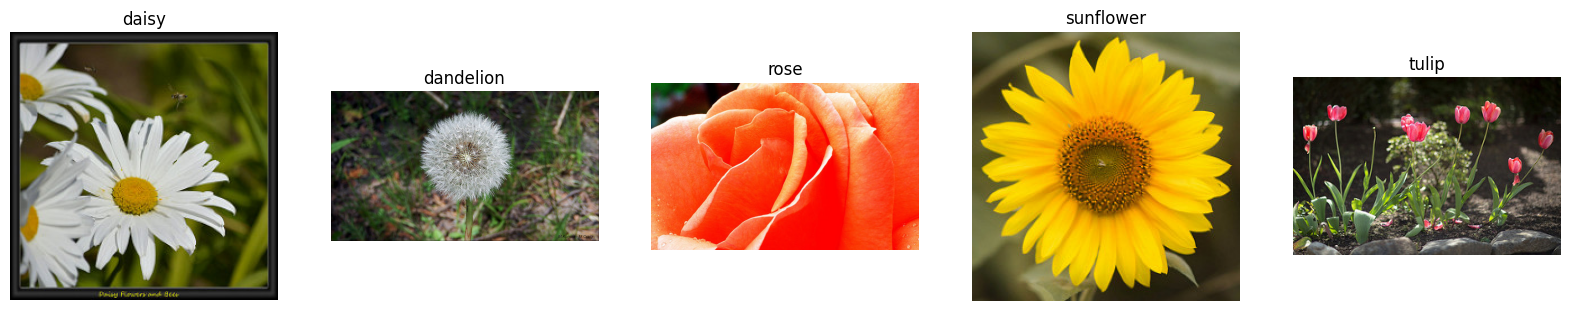

In [ ]:
fig, axs = plt.subplots(1, 5, figsize=(20, 5))

for i, cls in enumerate(classes[:5]):
    class_dir = os.path.join(TRAIN_DIR, cls)
    img_path = glob.glob(os.path.join(class_dir, '*'))[0]
    img = load_img(img_path)
    axs[i].imshow(img)
    axs[i].set_title(cls)
    axs[i].axis('off')

plt.show()

daisy: 501 images
dandelion: 646 images
rose: 497 images
sunflower: 495 images
tulip: 607 images


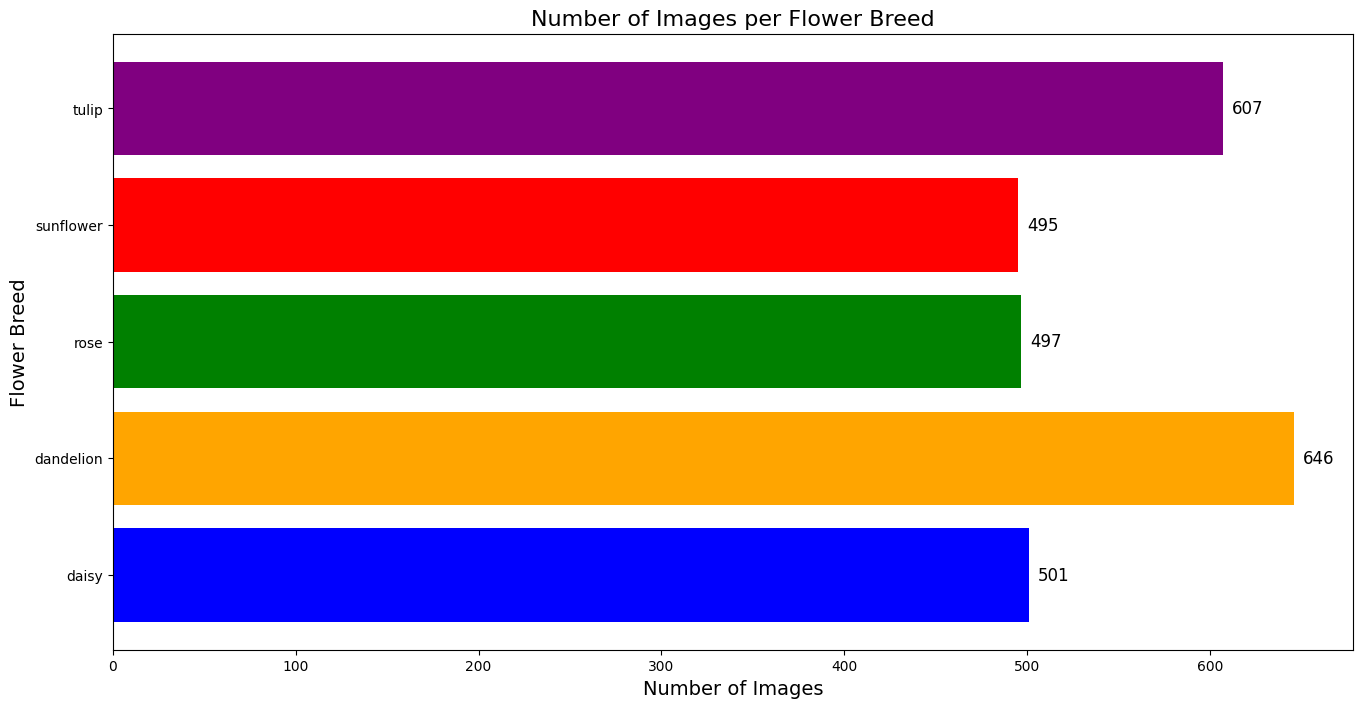

In [ ]:
# 각 클래스별 이미지 갯수 확인
counts = []
for class_name in classes:
    class_path = os.path.join(TRAIN_DIR, class_name)
    count = len(os.listdir(class_path))
    counts.append(count)
    print(f"{class_name}: {count} images")

plt.figure(figsize=(16, 8))

colors = ['blue', 'orange', 'green', 'red', 'purple']

bars = plt.barh(classes, counts, color=colors)

plt.xlabel('Number of Images', fontsize=14)
plt.ylabel('Flower Breed', fontsize=14)
plt.title('Number of Images per Flower Breed', fontsize=16)

for bar in bars:
    width = bar.get_width()
    plt.text(width + 5, bar.get_y() + bar.get_height()/2, int(width),
             va='center', ha='left', fontsize=12)

plt.show()

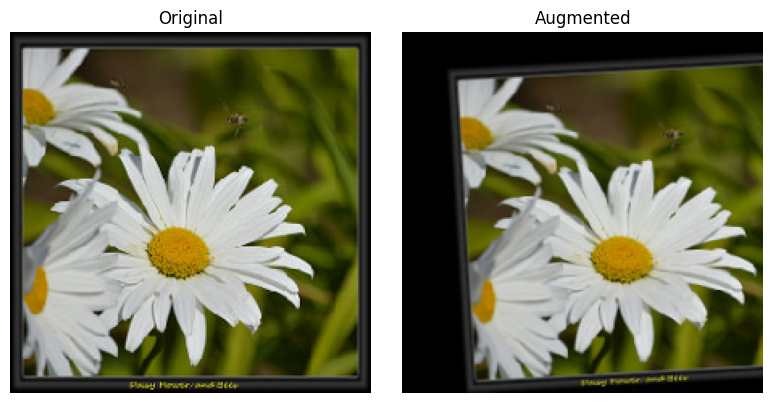

In [ ]:
aug_gen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.2,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest'
)

sample_class = classes[0]
sample_class_path = os.path.join(TRAIN_DIR, sample_class)
sample_image_name = os.listdir(sample_class_path)[0]
sample_image_path = os.path.join(sample_class_path, sample_image_name)
sample_img = load_img(sample_image_path, target_size=(224, 224))
sample_img_array = img_to_array(sample_img)

augmented_img_array = aug_gen.random_transform(sample_img_array)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(sample_img)
plt.title("Original")
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(augmented_img_array.astype('uint8'))
plt.title("Augmented")
plt.axis('off')
plt.tight_layout()
plt.show()

In [ ]:
BATCH_SIZE = 128
EPOCHS = 5
NUM_CLASSES = 5
vgg16_base = VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
vgg16_base.trainable = False  # 사전 학습된 가중치는 고정

model = Sequential([
    vgg16_base,
    Flatten(),
    Dense(256, activation='relu'),
    Dense(NUM_CLASSES, activation='softmax')
])

model.compile(optimizer=Adam(), loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ vgg16 (Functional)                   │ (None, 7, 7, 512)           │      14,714,688 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 256)                 │       6,422,784 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 5)                   │           1,285 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 21,138,757 (80.64 MB)

 Trainable params: 6,424,069 (24.51 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

In [ ]:
train_datagen = ImageDataGenerator(
    rescale=1/255.0,
    rotation_range=20,
    width_shift_range=0.1,
    height_shift_range=0.2,
    shear_range=0.1,
    zoom_range=0.1,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.2  # 20%를 validation으로 분리
)

train_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(224, 224),
    batch_size=BATCH_SIZE,
    class_mode='sparse',  # 정수형 라벨 사용
    subset='training',
    shuffle=True
)

validation_generator = train_datagen.flow_from_directory(
    TRAIN_DIR,
    target_size=(224, 224),
    batch_size=BATCH_SIZE,
    class_mode='sparse',
    subset='validation',
    shuffle=False
)

Found 2198 images belonging to 5 classes.
Found 548 images belonging to 5 classes.


In [ ]:
history = model.fit(
    train_generator,
    epochs=EPOCHS,
    validation_data=validation_generator
)

# 모델 평가 (validation 데이터로 평가)
loss, accuracy = model.evaluate(validation_generator)
print(f"Validation Loss: {loss:.4f}")
print(f"Validation Accuracy: {accuracy:.4f}")

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/5
18/18 ━━━━━━━━━━━━━━━━━━━━ 52s 2s/step - accuracy: 0.2662 - loss: 6.1965 - val_accuracy: 0.5109 - val_loss: 1.1281
Epoch 2/5
18/18 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.6166 - loss: 1.0148 - val_accuracy: 0.6405 - val_loss: 0.9225
Epoch 3/5
18/18 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.6912 - loss: 0.8277 - val_accuracy: 0.6989 - val_loss: 0.7897
Epoch 4/5
18/18 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.7572 - loss: 0.6945 - val_accuracy: 0.7172 - val_loss: 0.7403
Epoch 5/5
18/18 ━━━━━━━━━━━━━━━━━━━━ 31s 2s/step - accuracy: 0.8081 - loss: 0.5835 - val_accuracy: 0.7609 - val_loss: 0.6859
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 1s/step - accuracy: 0.7450 - loss: 0.6764
Validation Loss: 0.6875
Validation Accuracy: 0.7391


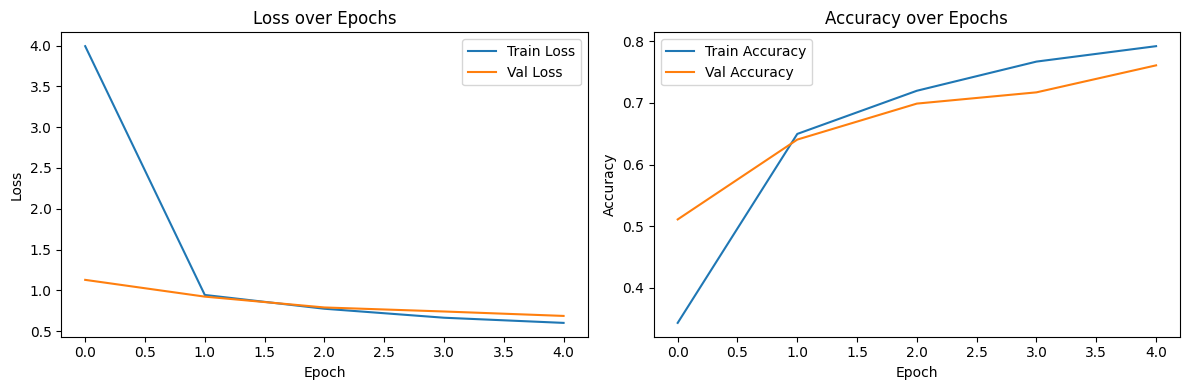

In [ ]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy over Epochs')
plt.legend()

plt.tight_layout()
plt.show()